In [1]:
#load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

## Import New Dataset

In [2]:
# Generating reproducible results from same code
tf.random.set_seed(14)  #Reference: https://www.youtube.com/watch?v=4ZhnXxfW8WQ&list=LL&index=1&t=1743s

In [3]:
raw_data = pd.read_csv("forestfires.csv")
raw_data.head() 
#Dummy variables are also created in this process. However we do not require them since we can use label encoding.

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [4]:
df = raw_data.copy() #Removing the dummies at this time
df.drop(df.columns[11:30],axis=1,inplace = True)

In [5]:
df.info() #No null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [6]:
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


<AxesSubplot:>

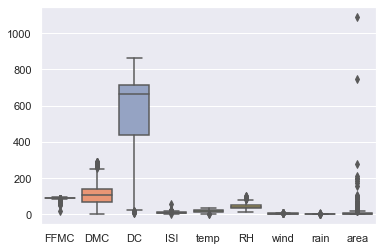

In [7]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=df, orient="v", palette="Set2") 
#There are outliers in the case of area. But we cannot discard it

## Feature Analysis

All features in the dataset can be used in model building. 

In [8]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [9]:
df.size_category.value_counts() # The dataset is biased. Lets remove the bias.

small    378
large    139
Name: size_category, dtype: int64

In [10]:
#We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


### Removing Bias in the Dataset

In [11]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 368, 0: 368})


### Train | Split dataset
#### Original Dataset

In [12]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

### Visualizing the data

Text(0.5, 1.0, 'T-Sine Visualization of forest-fire dataset')

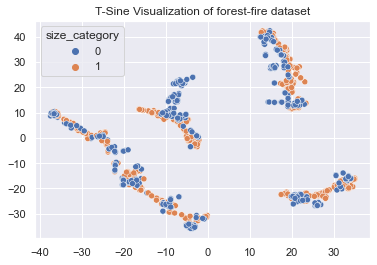

In [13]:
#Visualising the data via dimensionality reduction t-Sine Technique
from sklearn.manifold import TSNE

data_tsne_pca = TSNE(n_components=2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:,0],data_tsne_pca[:,1],hue=b, palette="deep").set_title('T-Sine Visualization of forest-fire dataset')

## Neural Network Modelling
#### Building the Model

In [14]:
import keras 
from keras.models import Sequential
from keras.layers import Dense

In [15]:
import keras
keras. __version__ #init method is not available in this mdethod

'2.10.0'

In [16]:
# create model
model1 = Sequential()
model1.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model1.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model1.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [17]:
# Compile model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Fit the model
hist1 = model1.fit(X_train, y_train, validation_split=0.33, epochs=30, batch_size=10)
#At epoch 25 itself our model reaches accuracy of 98% which maybe overfitting

Epoch 1/30
35/35 [==============================] - 1s 12ms/step - loss: 0.6917 - accuracy: 0.5739 - val_loss: 0.6915 - val_accuracy: 0.5176
Epoch 2/30
35/35 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.5536 - val_loss: 0.6801 - val_accuracy: 0.6176
Epoch 3/30
35/35 [==============================] - 0s 4ms/step - loss: 0.6556 - accuracy: 0.7072 - val_loss: 0.6205 - val_accuracy: 0.8882
Epoch 4/30
35/35 [==============================] - 0s 4ms/step - loss: 0.5770 - accuracy: 0.7623 - val_loss: 0.5343 - val_accuracy: 0.9235
Epoch 5/30
35/35 [==============================] - 0s 4ms/step - loss: 0.4779 - accuracy: 0.8290 - val_loss: 0.4398 - val_accuracy: 0.8176
Epoch 6/30
35/35 [==============================] - 0s 4ms/step - loss: 0.3833 - accuracy: 0.8812 - val_loss: 0.3511 - val_accuracy: 0.8588
Epoch 7/30
35/35 [==============================] - 0s 4ms/step - loss: 0.3227 - accuracy: 0.8899 - val_loss: 0.2732 - val_accuracy: 0.9176
Epoch 8/30
35/35 [=

In [19]:
model1.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                168       
                                                                 
 dense_1 (Dense)             (None, 12)                180       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


#### Model Evaluation

In [20]:
test_loss, test_acc = model1.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.2143 - accuracy: 0.9231


In [21]:
print(hist1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
hist1_df = pd.DataFrame(hist1.history)
hist1_df["epoch"]=hist1.epoch
hist1_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
25,0.034430,0.994203,0.044692,0.994118,25
26,0.038753,0.988406,0.046435,0.988235,26
27,0.033517,0.991304,0.042255,0.994118,27
28,0.053127,0.982609,0.048199,0.976471,28
29,0.053783,0.982609,0.207558,0.923529,29


#### Visualize Training History

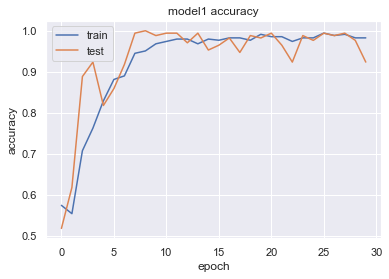

In [23]:
# summarize history for accuracy
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

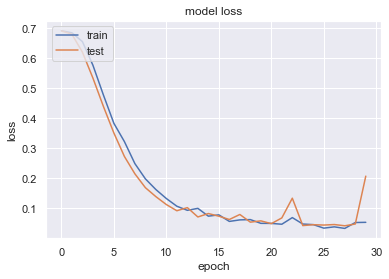

In [24]:
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #Loss decreases and starts oscillating after 25


## Tuning HyperParameters

#### Standardizing X values

In [25]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

In [26]:
# Importing the necessary packages
from sklearn.model_selection import GridSearchCV, KFold
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

#### Tuning set 1 : Batch Size and Epochs

In [27]:
# create model function
def create_model():
    model = Sequential()
    model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(12, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01) #learning rate = 0.01
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [28]:
# Create the model
model = KerasClassifier(build_fn = create_model,verbose = 0)
# Define the grid search parameters
batch_size = [10,20,40]
epochs = [10,25,50,100]
# Make a dictionary of the grid search parameters
param_grid = dict(batch_size = batch_size,epochs = epochs)
# Build and fit the GridSearchCV
grid = GridSearchCV(estimator = model,param_grid = param_grid,cv = KFold(),verbose = 10)
grid_result = grid.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=10, epochs=10...................................
[CV 1/5; 1/12] END ....batch_size=10, epochs=10;, score=1.000 total time=   2.0s
[CV 2/5; 1/12] START batch_size=10, epochs=10...................................
[CV 2/5; 1/12] END ....batch_size=10, epochs=10;, score=0.980 total time=   1.9s
[CV 3/5; 1/12] START batch_size=10, epochs=10...................................
[CV 3/5; 1/12] END ....batch_size=10, epochs=10;, score=0.898 total time=   1.9s
[CV 4/5; 1/12] START batch_size=10, epochs=10...................................
[CV 4/5; 1/12] END ....batch_size=10, epochs=10;, score=0.918 total time=   2.0s
[CV 5/5; 1/12] START batch_size=10, epochs=10...................................
[CV 5/5; 1/12] END ....batch_size=10, epochs=10;, score=0.973 total time=   2.0s
[CV 1/5; 2/12] START batch_size=10, epochs=25...................................
[CV 1/5; 2/12] END ....batch_size=10, epochs=25;

[CV 1/5; 11/12] END ...batch_size=40, epochs=50;, score=0.993 total time=   6.3s
[CV 2/5; 11/12] START batch_size=40, epochs=50..................................
[CV 2/5; 11/12] END ...batch_size=40, epochs=50;, score=0.966 total time=   3.2s
[CV 3/5; 11/12] START batch_size=40, epochs=50..................................
[CV 3/5; 11/12] END ...batch_size=40, epochs=50;, score=0.925 total time=   2.4s
[CV 4/5; 11/12] START batch_size=40, epochs=50..................................
[CV 4/5; 11/12] END ...batch_size=40, epochs=50;, score=0.959 total time=   2.5s
[CV 5/5; 11/12] START batch_size=40, epochs=50..................................
[CV 5/5; 11/12] END ...batch_size=40, epochs=50;, score=0.986 total time=   2.6s
[CV 1/5; 12/12] START batch_size=40, epochs=100.................................
[CV 1/5; 12/12] END ..batch_size=40, epochs=100;, score=0.993 total time=   4.3s
[CV 2/5; 12/12] START batch_size=40, epochs=100.................................
[CV 2/5; 12/12] END ..batch_

In [29]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print('{},{} with: {}'.format(mean, stdev, param))
#According to this, the best batch size is 20 and epochs is 50

Best : 0.9768799424171448, using {'batch_size': 20, 'epochs': 100}
0.9537414908409119,0.03881726635876104 with: {'batch_size': 10, 'epochs': 10}
0.9537414908409119,0.034257624665302654 with: {'batch_size': 10, 'epochs': 25}
0.9727982997894287,0.013619231640560902 with: {'batch_size': 10, 'epochs': 50}
0.9687166810035706,0.026037379389749173 with: {'batch_size': 10, 'epochs': 100}
0.955157208442688,0.02380952395209207 with: {'batch_size': 20, 'epochs': 10}
0.9687074899673462,0.03179133979429237 with: {'batch_size': 20, 'epochs': 25}
0.9728166937828064,0.012921885147953175 with: {'batch_size': 20, 'epochs': 50}
0.9768799424171448,0.018563436514617705 with: {'batch_size': 20, 'epochs': 100}
0.9347030758857727,0.04955409815892937 with: {'batch_size': 40, 'epochs': 10}
0.9646350383758545,0.023339734239219794 with: {'batch_size': 40, 'epochs': 25}
0.9659955859184265,0.023965298947593566 with: {'batch_size': 40, 'epochs': 50}
0.9741588473320008,0.024116167400065013 with: {'batch_size': 40, 'e

#### Tuning set 2 : Learning Rate and Dropout Rate

In [30]:
from keras.layers import Dropout

# Defining the model

def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

# Make a dictionary of the grid search parameters

param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)

# Build and fit the GridSearchCV

grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   3.7s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   3.7s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.966 total time=   3.6s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.959 total time=   3.7s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=1.000 total time=   3.6s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [31]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))
#Best score for Dropout rate = 0.2 and learning rate is 0.001

Best : 0.9823129296302795, using {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9809615731239318,0.015756591242603753 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9809523820877075,0.01170385310157046 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.9782312870025635,0.0189501907930002 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9823129296302795,0.0190476076943549 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9796010255813599,0.015520656763475525 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9523901462554931,0.04150006277678986 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9782312870025635,0.0189501907930002 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9782312989234925,0.027006022546905158 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.961904764175415,0.02456526537272912 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


#### Tuning set 3 : Activation Function and Kernel Initializer

In [32]:
# Defining the model

def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.101 total time=   5.8s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.803 total time=   5.0s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.476 total time=   5.5s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.524 total time=   5.7s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.122 total time=   4.2s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

[CV 3/5; 10/12] END activation_function=linear, init=uniform;, score=0.959 total time=   6.7s
[CV 4/5; 10/12] START activation_function=linear, init=uniform..................
[CV 4/5; 10/12] END activation_function=linear, init=uniform;, score=0.959 total time=   7.3s
[CV 5/5; 10/12] START activation_function=linear, init=uniform..................
[CV 5/5; 10/12] END activation_function=linear, init=uniform;, score=1.000 total time=   7.8s
[CV 1/5; 11/12] START activation_function=linear, init=normal...................
[CV 1/5; 11/12] END activation_function=linear, init=normal;, score=1.000 total time=   7.2s
[CV 2/5; 11/12] START activation_function=linear, init=normal...................
[CV 2/5; 11/12] END activation_function=linear, init=normal;, score=0.993 total time=   6.8s
[CV 3/5; 11/12] START activation_function=linear, init=normal...................
[CV 3/5; 11/12] END activation_function=linear, init=normal;, score=0.959 total time=   6.5s
[CV 4/5; 11/12] START activation_f

In [33]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))
#best activation function in our case would be Relu and Kernel Initializer is Uniform

Best : 0.9823129296302795, using {'activation_function': 'linear', 'init': 'uniform'}
0.4053042888641357,0.26434937926572416 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.40398971289396285,0.2603919540346259 with: {'activation_function': 'softmax', 'init': 'normal'}
0.3753814995288849,0.2922891258682248 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9809523820877075,0.02081231773837104 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9809523820877075,0.02081231773837104 with: {'activation_function': 'relu', 'init': 'normal'}
0.20136054158210753,0.18488389311191603 with: {'activation_function': 'relu', 'init': 'zero'}
0.9823129177093506,0.019527484330775252 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9823129177093506,0.019527484330775252 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20136054158210753,0.18488389311191603 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9823129296302795,0.0190476076943549 with: {'acti

#### Tuning Set 4: Number of neurons in activation layer

In [34]:
# Defining the model

def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

neuron1 = [4,8,14]
neuron2 = [4,8,12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=1.000 total time=   6.1s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.986 total time=   5.9s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.959 total time=   5.9s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.946 total time=   6.4s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.803 total time=   6.2s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [35]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

#Best results are Neuron 1 = 4 and Neuron 2 = 4

Best : 0.9809523820877075, using {'neuron1': 14, 'neuron2': 8}
0.9387755155563354,0.07069595776710406 with: {'neuron1': 4, 'neuron2': 4}
0.9496598601341247,0.042721953119643524 with: {'neuron1': 4, 'neuron2': 8}
0.9755102157592773,0.01952748765305751 with: {'neuron1': 4, 'neuron2': 12}
0.9795918345451355,0.01971614943695823 with: {'neuron1': 8, 'neuron2': 4}
0.9755102038383484,0.01752937797251437 with: {'neuron1': 8, 'neuron2': 8}
0.9795918345451355,0.022356019349977815 with: {'neuron1': 8, 'neuron2': 12}
0.9809523701667786,0.013874890051800664 with: {'neuron1': 14, 'neuron2': 4}
0.9809523820877075,0.02081231773837104 with: {'neuron1': 14, 'neuron2': 8}
0.9809523820877075,0.018950192504749705 with: {'neuron1': 14, 'neuron2': 12}


#### Tuning set 5: Trying all HyperParameters at once

In [36]:
'''def create_model5(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

# Create the model

#model5 = KerasClassifier(build_fn = create_model5,verbose = 0)

# Define the grid search parameters

batch_size = [10,20,40]
epochs = [10,50,100]
learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]
activation_function = ['relu','tanh','linear'] #removing softmax since it is for multiclass
init = ['uniform','normal']
neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters

param_grids5 = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid5 = GridSearchCV(estimator = model5,param_grid = param_grids5,cv = KFold(),verbose = 10)
grid_result5 = grid5.fit(X_standardized,Y)
'''
#This would take approx 15 hours to complete

"def create_model5(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):\n    model = Sequential()\n    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = init,activation = activation_function))\n    model.add(Dropout(dropout_rate))\n    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))\n    model.add(Dropout(dropout_rate))\n    model.add(Dense(1,activation = 'sigmoid'))\n    \n    adam = Adam(lr = learning_rate)\n    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])\n    return model\n\n# Create the model\n\n#model5 = KerasClassifier(build_fn = create_model5,verbose = 0)\n\n# Define the grid search parameters\n\nbatch_size = [10,20,40]\nepochs = [10,50,100]\nlearning_rate = [0.001,0.01,0.1]\ndropout_rate = [0.0,0.1,0.2]\nactivation_function = ['relu','tanh','linear'] #removing softmax since it is for multiclass\ninit = ['uniform','normal']\nneuron1 = [4,8,16]\nneuron2 = [2

## Building Final Model

In [37]:
# Defining the model

def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [38]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)

In [39]:
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)


In [40]:
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [41]:
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))


In [42]:
report_model(model_fnl)

7/7 [==============================] - 0s 4ms/step
[[ 98   3]
 [  1 119]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       101
           1       0.98      0.99      0.98       120

    accuracy                           0.98       221
   macro avg       0.98      0.98      0.98       221
weighted avg       0.98      0.98      0.98       221



## Conclusion
- EDA was perfomed on initial dataset and all errors were removed.
- Inbuilt databias of the dataset was rectified.
- A general Neural Network was built first using random Parameters.
- Training history plotting was done for the above model.
- Tuning of HyperParameters was perfomed
- An optimised Final Model was built with all the optimum hyperparameters.
- Final model report was obtained.